In [16]:
import skdim

import cupy as cp
import numpy as np
from numba import jit, njit

from scipy.spatial.distance import cdist

import time

import matplotlib.pyplot as plt

In [17]:
def pairwise_distance_matrix(points):
    squared_distances = np.sum(points ** 2, axis=1, keepdims=True) 
    squared_distances = squared_distances + np.sum(points ** 2, axis=1) 
    squared_distances = squared_distances - 2 * np.dot(points, points.T)
    distance_matrix = np.sqrt(np.maximum(squared_distances, 0))
    return distance_matrix

def pairwise_distance_matrix_cp(points):
    squared_distances = cp.sum(points ** 2, axis=1, keepdims=True) 
    squared_distances = squared_distances + cp.sum(points ** 2, axis=1) 
    squared_distances = squared_distances - 2 * cp.dot(points, points.T)
    distance_matrix = cp.sqrt(cp.maximum(squared_distances, 0))
    return distance_matrix

@njit
def pairwise_distance_matrix_nb(points):
    squared_distances = np.sum(points ** 2, axis=1, keepdims=True) 
    squared_distances = squared_distances + np.sum(points ** 2, axis=1) 
    squared_distances = squared_distances - 2 * np.dot(points, points.T)
    distance_matrix = np.sqrt(np.maximum(squared_distances, 0))
    return distance_matrix

In [4]:
n_points_grid = [100, 500, 1_000, 2_000, 5_000, 7_500, 10_000]
n_points_default = 5000

space_dim_grid = [10, 50, 100, 500, 1000]
space_dim_default = 100

In [5]:
numpy_points_times = []

for n_space_points in n_points_grid:
    X = np.zeros((n_space_points, space_dim_default))
    X[:,:5] = skdim.datasets.hyperBall(n=n_space_points, d=5, radius=1, random_state=0)
    
    cur_times = []
    for _ in range(5):
        start = time.perf_counter()
        res = pairwise_distance_matrix(X)
        end = time.perf_counter()

        cur_times.append(end - start)

    numpy_points_times.append(np.mean(cur_times))


numpy_dim_times = []

for dim in space_dim_grid:
    X = np.zeros((n_points_default, dim))
    X[:,:5] = skdim.datasets.hyperBall(n=n_points_default, d=5, radius=1, random_state=0)
    
    cur_times = []
    for _ in range(5):
        start = time.perf_counter()
        res = pairwise_distance_matrix(X)
        end = time.perf_counter()

        cur_times.append(end - start)

    numpy_dim_times.append(np.mean(cur_times))

In [6]:
cupy_points_times = []

for n_space_points in n_points_grid:
    X = np.zeros((n_space_points, space_dim_default))
    X[:,:5] = skdim.datasets.hyperBall(n=n_space_points, d=5, radius=1, random_state=0)
    
    cur_times = []
    for _ in range(5):
        start = time.perf_counter()
        res = pairwise_distance_matrix_cp(cp.asarray(X)).get()
        cp.cuda.Device(0).synchronize()
        end = time.perf_counter()

        cur_times.append(end - start)

    cupy_points_times.append(np.mean(cur_times))


cupy_dim_times = []

for dim in space_dim_grid:
    X = np.zeros((n_points_default, dim))
    X[:,:5] = skdim.datasets.hyperBall(n=n_points_default, d=5, radius=1, random_state=0)
    
    cur_times = []
    for _ in range(5):
        start = time.perf_counter()
        res = pairwise_distance_matrix_cp(cp.asarray(X)).get()
        cp.cuda.Device(0).synchronize()
        end = time.perf_counter()

        cur_times.append(end - start)

    cupy_dim_times.append(np.mean(cur_times))

In [7]:
numba_points_times = []

for n_space_points in n_points_grid:
    X = np.zeros((n_space_points, space_dim_default))
    X[:,:5] = skdim.datasets.hyperBall(n=n_space_points, d=5, radius=1, random_state=0)
    
    cur_times = []
    for _ in range(5):
        start = time.perf_counter()
        res = pairwise_distance_matrix_nb(X)
        end = time.perf_counter()

        cur_times.append(end - start)

    numba_points_times.append(np.mean(cur_times))


numba_dim_times = []

for dim in space_dim_grid:
    X = np.zeros((n_points_default, dim))
    X[:,:5] = skdim.datasets.hyperBall(n=n_points_default, d=5, radius=1, random_state=0)
    
    cur_times = []
    for _ in range(5):
        start = time.perf_counter()
        res = pairwise_distance_matrix_nb(X)
        end = time.perf_counter()

        cur_times.append(end - start)

    numba_dim_times.append(np.mean(cur_times))

In [8]:
scipy_points_times = []

for n_space_points in n_points_grid:
    X = np.zeros((n_space_points, space_dim_default))
    X[:,:5] = skdim.datasets.hyperBall(n=n_space_points, d=5, radius=1, random_state=0)
    
    cur_times = []
    for _ in range(5):
        start = time.perf_counter()
        res = cdist(X, X)
        end = time.perf_counter()

        cur_times.append(end - start)

    scipy_points_times.append(np.mean(cur_times))


scipy_dim_times = []

for dim in space_dim_grid:
    X = np.zeros((n_points_default, dim))
    X[:,:5] = skdim.datasets.hyperBall(n=n_points_default, d=5, radius=1, random_state=0)
    
    cur_times = []
    for _ in range(5):
        start = time.perf_counter()
        res = cdist(X, X)
        end = time.perf_counter()

        cur_times.append(end - start)

    scipy_dim_times.append(np.mean(cur_times))

Text(0.5, 0.98, 'Pairwise distance matrix computation time')

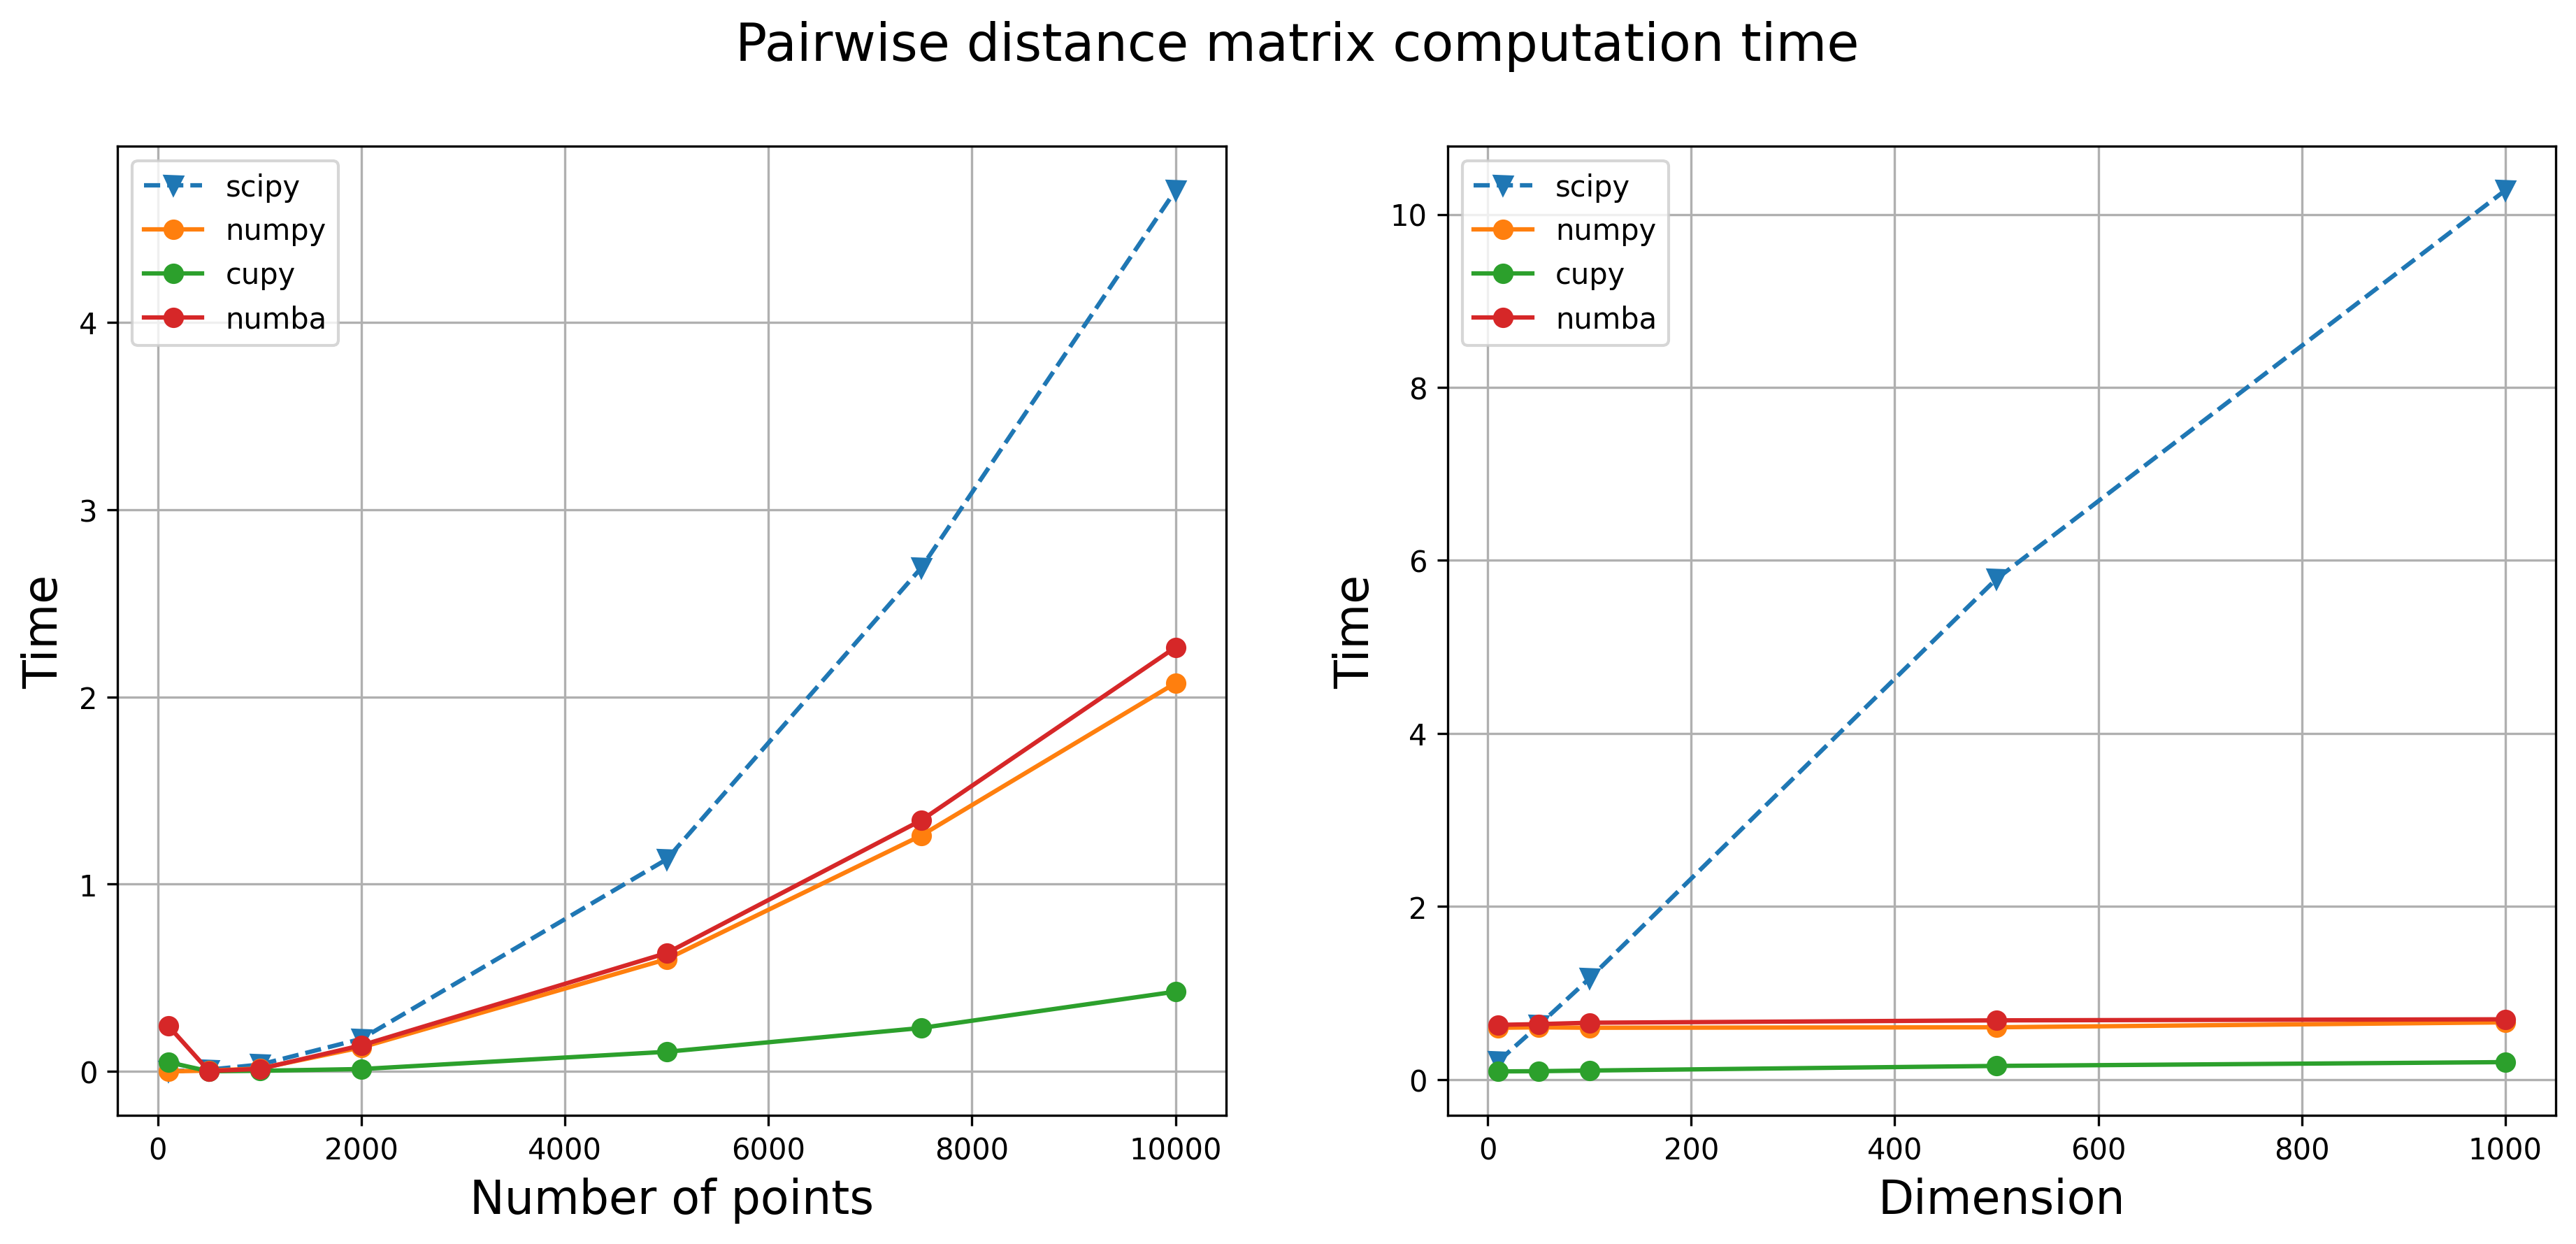

In [21]:
fig, axes = plt.subplots(1, 2, figsize=(15, 6), dpi=300)

axes[0].plot(n_points_grid, scipy_points_times, label='scipy', marker='v', linestyle='--')
axes[0].plot(n_points_grid, numpy_points_times, label='numpy', marker='o')
axes[0].plot(n_points_grid, cupy_points_times, label='cupy', marker='o')
axes[0].plot(n_points_grid, numba_points_times, label='numba', marker='o')

axes[0].set_ylabel('Time', fontsize=16)
axes[0].set_xlabel('Number of points', fontsize=16)
axes[0].grid()
axes[0].legend()

axes[1].plot(space_dim_grid, scipy_dim_times, label='scipy', marker='v', linestyle='--')
axes[1].plot(space_dim_grid, numpy_dim_times, label='numpy', marker='o')
axes[1].plot(space_dim_grid, cupy_dim_times, label='cupy', marker='o')
axes[1].plot(space_dim_grid, numba_dim_times, label='numba', marker='o')

axes[1].set_ylabel('Time', fontsize=16)
axes[1].set_xlabel('Dimension', fontsize=16)
axes[1].grid()
axes[1].legend()

plt.suptitle('Pairwise distance matrix computation time', fontsize=18)